# **Introduction to Building Agents**

In this notebook we are going to first see how to build a basic agent.

Later we will use LangGraph to build powerful agents.

## **Step 1 - Initializing a Large Language Model**

In [1]:
from langchain_openai import ChatOpenAI

/Users/kanavbansal/Developer/.env_jupyter/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Setup API Key

f = open('keys/.openai_api_key.txt')

OPENAI_API_KEY = f.read()

In [3]:
llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY,
                 model="gpt-4o-mini",
                 temperature=0.0)

llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-c1be51c1-aaf5-447a-833d-bc3f70d3f366-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## **Step 2 - Initializing a Tool**

In [4]:
from langchain_core.tools import tool
from datetime import datetime

@tool
def current_datetime():
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"The current date and time is {current_datetime}"

current_datetime.invoke({})

'The current date and time is 2025-03-03 13:19:40'

## **Step 3 - Init an Agent (i.e. Binding the Tool with a LLM)**

In [5]:
llm_with_tool = llm.bind_tools([current_datetime])

llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x10c7befd0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x10c7c21c0>, root_client=<openai.OpenAI object at 0x106069700>, root_async_client=<openai.AsyncOpenAI object at 0x10c7bef70>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'current_datetime', 'description': 'This function tells the current date and time.', 'parameters': {'properties': {}, 'type': 'object'}}}]}, config={}, config_factories=[])

In [6]:
response = llm_with_tool.invoke("Hi")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: Hello! How can I assist you today?
Tool Call: []


In [7]:
response.pretty_print()

================================== Ai Message ==================================

Hello! How can I assist you today?


In [8]:
response = llm_with_tool.invoke("What is the current date?")

print(f"Content: {response.content}")
print(f"Tool Call: {response.tool_calls}")

Content: 
Tool Call: [{'name': 'current_datetime', 'args': {}, 'id': 'call_UssXSv5lV2UnbitJHbWeayWN', 'type': 'tool_call'}]


In [9]:
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_UssXSv5lV2UnbitJHbWeayWN)
 Call ID: call_UssXSv5lV2UnbitJHbWeayWN
  Args:


## **Step 4 - Tool Call and Executing the Agent**

In [10]:
dict_with_tool_names = {
    "current_datetime": current_datetime,
}

def custom_agent_executor(response):
    if response.tool_calls:
        for tool_calls in response.tool_calls:
            tool_name = tool_calls["name"]
            tool_args = tool_calls["args"]
            tool_func = dict_with_tool_names[tool_name]
            return tool_func.invoke(tool_args)
    else:
        return response.content

In [11]:
custom_agent_executor(llm_with_tool.invoke("Hi"))

'Hello! How can I assist you today?'

In [12]:
custom_agent_executor(llm_with_tool.invoke("What is the time?"))

'The current date and time is 2025-03-03 13:19:46'

# **A Better Implementation**

## **Step 1 - Init a LLM**

## **Step 2 - Init a Tool**

In [13]:
from datetime import datetime

def current_datetime() -> str:
    """This function tells the current date and time."""
    current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"The current date and time is {current_datetime}"

current_datetime()

'The current date and time is 2025-03-03 13:19:46'

## **Step 3 - Init an Agent**

In [14]:
# ! pip install langgraph

In [15]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(model=llm, tools=[current_datetime])

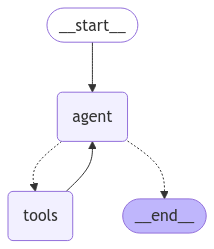

In [16]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

**IMPORTANT:** Note that we are passing in the **llm**, not **llm_with_tools**. That is because **create_react_agent** will call **.bind_tools** for us under the hood.

## **Step 4 - Execute the Agent**

In [17]:
response = agent_executor.invoke({"messages": "Hi"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [18]:
response = agent_executor.invoke({"messages": "What is the time?"})

for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

What is the time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_JMIHHhBB57usCG5LM7XERAuf)
 Call ID: call_JMIHHhBB57usCG5LM7XERAuf
  Args:
================================= Tool Message =================================
Name: current_datetime

The current date and time is 2025-03-03 13:19:51
================================== Ai Message ==================================

The current time is 13:19:51 (1:19 PM).


## **Step 5 - Pretty Print**

In [19]:
def printer(input_prompt):
    for s in agent_executor.stream(input_prompt, stream_mode="values"):
        msg = s["messages"][-1]
        if isinstance(msg, tuple):
            print("tuple:", msg)
        else:
            msg.pretty_print()

In [20]:
printer(input_prompt={"messages": "hi"})

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [21]:
printer(input_prompt={"messages": "time?"})

================================ Human Message =================================

time?
================================== Ai Message ==================================
Tool Calls:
  current_datetime (call_0ZnZmVHHZPVuvh21FFLi4xM2)
 Call ID: call_0ZnZmVHHZPVuvh21FFLi4xM2
  Args:
================================= Tool Message =================================
Name: current_datetime

The current date and time is 2025-03-03 13:19:54
================================== Ai Message ==================================

The current date and time is March 3, 2025, at 13:19:54.
